In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
plt.style.use(["science","no-latex", "/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle"])
# plt.style.use(["/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle"])
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

In [2]:
from LoadMultiFiles import LoadMultiFilesDataframe
dict_to_df = {"ion":[], "time":[], "chamberID":[], "BeamX":[], "BeamZ":[], "Ek":[], "dE_quench":[]}
dict_nEvts = {}
# template_root_path = "/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/root_addEvtIDinGen/{}_10cm_*.root"
template_root_path = "/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/root/hadd_{}_*.root"
v_particles_total = ["H_2","He_4",   "Li_6", "B_10", "C_12", "N_14","O_16", "F_18", "Ne_20", "Na_22"]
# v_particles = ["H_2","He_4",   "Li_6", "B_10", "C_12", "N_14","O_16", "F_18", "Ne_20", "Na_22"]
load_pkl = True
dict_replace_chamberID = {i:f"{90-i*18} deg" for i in range(6)}

df_time = LoadMultiFilesDataframe("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/pkl/PMT_far_*.pkl",
                                  {"chamberID":[0,12]})
v_particles_subset = set(list(df_time["ion"]))
v_particles = [ particle   for particle in v_particles_total if particle in v_particles_subset]

df_time

,BeamX,BeamZ,Ek,chamberID,dE_quench,ion,time,theta,bin_BeamX,bin_BeamZ
0,-3.532084,-6.409580,0.000003,4,0.597404,H_2,17.203315,18 deg,"(-5.0, 5.0]","(-15.0, -5.0]"
1,-11.012629,0.320354,0.000003,1,0.571012,H_2,9.358603,72 deg,"(-15.0, -5.0]","(-5.0, 5.0]"
2,-4.130361,-23.262560,0.000003,1,0.740118,H_2,43.838123,72 deg,"(-5.0, 5.0]","(-25.0, -15.0]"
3,12.276237,-3.747188,0.000003,3,0.622032,H_2,22.879265,36 deg,"(5.0, 15.0]","(-5.0, 5.0]"
4,-16.762304,-9.187138,0.000003,4,0.581664,H_2,6.234390,18 deg,"(-25.0, -15.0]","(-15.0, -5.0]"
...,...,...,...,...,...,...,...,...,...,...
2683560,16.978046,-12.047625,0.000003,5,39.863166,Na_22,5.417773,0 deg,"(15.0, 25.0]","(-15.0, -5.0]"
2683561,16.978046,-12.047625,0.000003,3,39.863166,Na_22,9.669410,36 deg,"(15.0, 25.0]","(-15.0, -5.0]"
2683562,16.978046,-12.047625,0.000003,3,39.863166,Na_22,8.504564,36 deg,"(15.0, 25.0]","(-15.0, -5.0]"
2683563,16.978046,-12.047625,0.000003,5,39.863166,Na_22,16.198644,0 deg,"(15.0, 25.0]","(-15.0, -5.0]"


In [ ]:
from RooFitTools import ArrayToTree
from HistTools import GetBinCenter
dict_tree = {}
for particle in v_particles:
    h = plt.hist(df_time[(df_time["ion"]==particle)&(df_time["chamberID"]==0)]["time"], bins=np.linspace(-10, 30,500),
                 histtype="step", label=particle)

    dict_tree[particle] = ArrayToTree(np.array(df_time[(df_time["ion"]==particle)&(df_time["chamberID"]==0)]["time"])-GetBinCenter(h[1])[np.argmax(h[0])], "time")
plt.legend()
plt.title("Time [ ns ]")
# tree_time.Scan()



In [ ]:
# from RooFitFunctionForTimeConstant import FitTimeProfileWithTruth
# FitTimeProfileWithTruth("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/AnalysisCode/fitResult/FitResult.pdf",
#                         dict_tree, "Ion")

# Fit Time Profile

In [ ]:
import ROOT
import tqdm
t_upper = 1500
dict_param = {"Ion":[], "tau1":[], "tau2":[], "tau3":[], "N1":[], "N2":[], "N3":[]}
v_keys = dict_param.keys()
for key in list(v_keys):
    if key!="Ion":
        dict_param[key+"_error"] = []

t = ROOT.RooRealVar("time", "Time [ns]", 0, t_upper, "" )
tau1 = ROOT.RooRealVar("#tau_{1}", "tau1", 4, 0., 800.)
tau2 = ROOT.RooRealVar("#tau_{2}", "tau2", 25., 0., 800.)
tau3 = ROOT.RooRealVar("#tau_{3}", "tau3", 200, 100., 800.)
eta1 = ROOT.RooRealVar("#eta_{1}", "eta1", 0.7, 0., 1.)
eta2 = ROOT.RooRealVar("#eta_{2}", "eta2", 0.2, 0., 1.)
Nhit = ROOT.RooRealVar("N_{hit}", "Nhit", 10000, 1.e3, 1.e6)
# Ndark = ROOT.RooRealVar("N_{dark}", "Ndark", 0)

lambda1 = ROOT.RooFormulaVar ("lambda1", "lambda1", "-1./@0", ROOT.RooArgList(tau1))
lambda2 = ROOT.RooFormulaVar ("lambda2", "lambda2", "-1./@0", ROOT.RooArgList(tau2))
lambda3 = ROOT.RooFormulaVar ("lambda3", "lambda3", "-1./@0", ROOT.RooArgList(tau3))

exp1 = ROOT.RooExponential ("exp1", "exp1 distribution", t, lambda1)
exp2 = ROOT.RooExponential ("exp2", "exp2 distribution", t, lambda2)
exp3 = ROOT.RooExponential ("exp3", "exp3 distribution", t, lambda3)

bpN1 = ROOT.RooFormulaVar("bpN1", "bpN1", "@0*@1", ROOT.RooArgList(Nhit, eta1))
bpN2 = ROOT.RooFormulaVar("bpN2", "bpN2", "@0*@1", ROOT.RooArgList(Nhit, eta2))
bpN3 = ROOT.RooFormulaVar("bpN3", "bpN3", "@0*(1.-@1-@2)", ROOT.RooArgList(Nhit, eta1, eta2))
# bpdark=ROOT.RooFormulaVar("bpdark", "bpdark", "@0*(900.-40.)", ROOT.RooArgList(Ndark))

# polybkg1 = ROOT.RooPolynomial("polybkg1", "bkg1 distribution", t, ROOT.RooArgList());

# ffpoly = TF1("ffpoly", "[0]", -200, -100)
# h_time_rising_edge->Fit(ffpoly, "RL")
# double ndarkfit = ffpoly->GetParameter(0) * (xhigh - 40);
# double ndarkerrfit = ffpoly->GetParError(0) * (xhigh - 40);
# Ndark.setVal(ndarkfit);
# Ndark.setError(ndarkerrfit);

sum1 = ROOT.RooAddPdf("sum1", "sum1", ROOT.RooArgList(exp1, exp2, exp3), ROOT.RooArgList(bpN1, bpN2, bpN3))

name_pdf = "/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/AnalysisCode/fitResult/FitResult.pdf"
c1 = ROOT.TCanvas("c_0")
c1.Print(name_pdf+"[")
v_particles = list(v_particles)
for i,particle in tqdm.tqdm(enumerate(v_particles)):
# particle = "H_2"
    data = ROOT.RooDataSet("data", "data", ROOT.RooArgSet(t), ROOT.RooFit.Import(dict_tree[particle]))

    fitresult = sum1.fitTo(data, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Extended(True))
    dict_param["Ion"].append(particle)
    dict_param["N1"].append(eta1.getVal(0))
    dict_param["N2"].append(eta2.getVal(0))
    dict_param["N3"].append(1-(eta1.getVal(0)+eta2.getVal(0)))
    dict_param["tau1"].append(tau1.getVal(0))
    dict_param["tau2"].append(tau2.getVal(0))
    dict_param["tau3"].append(tau3.getVal(0))
    dict_param["N1_error"].append(eta1.getError())
    dict_param["N2_error"].append(eta2.getError())
    dict_param["N3_error"].append(pow(pow(eta1.getError(),2)+pow(eta2.getError(),2),0.5 ))
    dict_param["tau1_error"].append(tau1.getError())
    dict_param["tau2_error"].append(tau2.getError())
    dict_param["tau3_error"].append(tau3.getError())

    # fitresult.Print()

    xframe = t.frame(ROOT.RooFit.Title(particle))
    #gPad->SetLogy();
    data.plotOn(xframe)
    # sum1.plotOn(xframe, ROOT.RooFit.Components(ROOT.RooArgSet(exp1)), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kBlue))
    # sum1.plotOn(xframe, ROOT.RooFit.Components(ROOT.RooArgSet(exp2)), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kBlue))
    # sum1.plotOn(xframe, ROOT.RooFit.Components(ROOT.RooArgSet(exp3)), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kBlue))
    # // sum1->plotOn(xframe, Components(RooArgSet(exp3)), LineStyle(kDashed), RooFit.LineColor(kOrange + 2));
    # sum1->plotOn(xframe, Components(RooArgSet(polybkg1)), LineStyle(kDotted), RooFit.LineColor(kGreen));
    sum1.plotOn(xframe, ROOT.RooFit.LineStyle(1), ROOT.RooFit.LineColor(2))
    # chi2 = xframe.chiSquare("fit","data",7)
    # chi2Line = ROOT.RooFit.Format("Chisquare = %f ",chi2)
    # sum1.paramOn(xframe,ROOT.RooFit.Layout(0.7,0.9,0.9), ROOT.RooFit.Label(chi2Line))
    sum1.paramOn(xframe)
    xframe.GetYaxis().SetRangeUser(0.01, 100000)
    ROOT.gPad.SetLogy()

    xframe.Draw()
    c1.cd()
    c1.Print(name_pdf)
    # c1.SaveAs(f"/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/AnalysisCode/fitResult/{particle}.png")
    xframe.Delete()
    c1.Clear()

c1.Print(name_pdf)
c1.Print(name_pdf+"]")
c1.Close()
#

# Get dE/dx Error Bar

# Plot Fit Results

In [ ]:
dict_param["dE/dx"] = []
with np.load("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/run/BeamEnergy.npz",allow_pickle=True) as f:
    for name_ion, dE_dx in zip(f["name"],f["dE_dx"]):
        if name_ion in list(dict_param["Ion"]):
            dict_param["dE/dx"].append(dE_dx)
print(dict_param)
df_param = pd.DataFrame.from_dict(dict_param)

df_param

In [ ]:
v_name_timing_constant = ["N1", "tau1", "N2", "tau2", "N3", "tau3"]
dir_mean_dE_dx_with_quench = {'alpha': 122.773224, 'Co60': 0.6747912, 'AmC': 29.574236}
dir_v_timing_constant = {}
# dir_v_timing_constant["gamma"] = [79.9,4.93,17.1,20.6,3,190]
# dir_v_timing_constant["neutron"] = [65,4.93,23.1,34,11.9,220]
dir_v_timing_constant["Co60"] = [79.9,4.93,17.1,20.6,3,190]
dir_v_timing_constant["AmC"] = [65,4.93,23.1,34,11.9,220]
dir_v_timing_constant["alpha"] = [65,4.93,22.8,35,12.2,220]

# Normalization of parameters N*
for particle in dir_v_timing_constant.keys():
    for i in range(len(v_name_timing_constant)):
        if "N" in v_name_timing_constant[i]:
            dir_v_timing_constant[particle][i] = dir_v_timing_constant[particle][i]*0.01
print(dir_v_timing_constant)


n_figures = len(v_name_timing_constant)
fig,axs = plt.subplots(6,1,sharex="col",figsize=(8,9))
colors = ["b","g","r","c","m","y","k","w"]
dir_v_x = {}
dir_v_y = {}
for i_constant in range(6):
    # plt.figure()
    # ax = plt.subplot(n_figures*100+10+1+i_constant)
    v_x = []
    v_y = []
    for particle in dir_v_timing_constant.keys():
        v_x.append(dir_mean_dE_dx_with_quench[particle])
        v_y.append(dir_v_timing_constant[particle][i_constant])
    axs[i_constant].plot(v_x, v_y, color=colors[i_constant], label=v_name_timing_constant[i_constant])
    axs[i_constant].scatter(v_x,v_y, color=colors[i_constant])
    dir_v_x[v_name_timing_constant[i_constant]] = v_x
    dir_v_y[v_name_timing_constant[i_constant]] = v_y
    axs[i_constant].legend()

    axs[i_constant].errorbar(df_param["dE/dx"], df_param[v_name_timing_constant[i_constant]],
                             yerr=df_param[v_name_timing_constant[i_constant]+"_error"],
                             color='black', ls='none', marker='o', capsize=5, capthick=1, ecolor='black',
                             markersize=5)
    axs[i_constant].set_xlim(0,60)
plt.xlabel("dE/dx [ MeV/mm ]")
axs[0].set_title("Time Constant")




In [2]:
v_name_timing_constant = ["N1", "tau1", "N2", "tau2"]
dir_mean_dE_dx_with_quench = {'alpha': 122.773224, 'Co60': 0.6747912, 'AmC': 29.574236}
dir_v_timing_constant = {}

dir_v_timing_constant["Co60"] = [79.9,4.93,17.1,20.6,3,190]
dir_v_timing_constant["AmC"] = [65,4.93,23.1,34,11.9,220]
dir_v_timing_constant["alpha"] = [65,4.93,22.8,35,12.2,220]



{'Co60': [0.799, 4.93, 0.171, 20.6, 3, 190], 'AmC': [0.65, 4.93, 0.231, 34, 11.9, 220], 'alpha': [0.65, 4.93, 0.228, 35, 12.2, 220]}


NameError: name 'df_param' is not defined

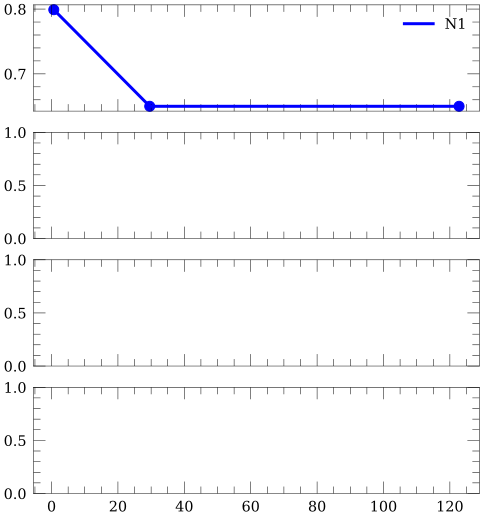

In [3]:

# Normalization of parameters N*
for particle in dir_v_timing_constant.keys():
    for i in range(len(v_name_timing_constant)):
        if "N" in v_name_timing_constant[i]:
            dir_v_timing_constant[particle][i] = dir_v_timing_constant[particle][i]*0.01
print(dir_v_timing_constant)


n_figures = len(v_name_timing_constant)
fig,axs = plt.subplots(4,1,sharex="col",figsize=(8,9))
colors = ["b","g","r","c","m","y","k","w"]
dir_v_x = {}
dir_v_y = {}
for i_constant in range(4):
    # plt.figure()
    # ax = plt.subplot(n_figures*100+10+1+i_constant)
    v_x = []
    v_y = []
    for particle in dir_v_timing_constant.keys():
        v_x.append(dir_mean_dE_dx_with_quench[particle])
        v_y.append(dir_v_timing_constant[particle][i_constant])
    axs[i_constant].plot(v_x, v_y, color=colors[i_constant], label=v_name_timing_constant[i_constant])
    axs[i_constant].scatter(v_x,v_y, color=colors[i_constant])
    dir_v_x[v_name_timing_constant[i_constant]] = v_x
    dir_v_y[v_name_timing_constant[i_constant]] = v_y
    axs[i_constant].legend()

    axs[i_constant].errorbar(df_param["dE/dx"], df_param[v_name_timing_constant[i_constant]],
                             yerr=df_param[v_name_timing_constant[i_constant]+"_error"],
                             color='black', ls='none', marker='o', capsize=5, capthick=1, ecolor='black',
                             markersize=5)
    axs[i_constant].set_xlim(0,60)
plt.xlabel("dE/dx [ MeV/mm ]")
axs[0].set_title("Time Constant")